# KARPHY'S CNN 
The notebook is used to experiment with video classification using karphy's CNN as discussed in https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42455.pdf

In [14]:
import tensorflow as tf
# import keras
# tf.enable_eager_execution()
tf.compat.v1.enable_eager_execution()
import tensorflow_datasets as tfds
import os
import zipfile
# from tensorflow.keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pydot


## Reading in data
The "ucf101" dataset from tensorflow will be used. More information on this dataset can be found here URL: https://www.crcv.ucf.edu/data/UCF101.php

In [15]:
ucf101_dataset, ucf101_info = tfds.load(name="ucf101", with_info=True)
ucf101_train , ucf101_test = ucf101_dataset["train"], ucf101_dataset["test"]
print(type(ucf101_info))
assert isinstance(ucf101_train, tf.data.Dataset)
assert isinstance(ucf101_test, tf.data.Dataset)

print('number of training examples:', ucf101_info.splits["train"].num_examples)
print('number of test examples:', ucf101_info.splits["test"].num_examples)
print('number of labels:', ucf101_info.features["label"].num_classes)

<class 'tensorflow_datasets.core.dataset_info.DatasetInfo'>
number of training examples: 9537
number of test examples: 3783
number of labels: 101


### Looking into the dataset
The dataset has a pixel size of 256 x 256 x 3 for each video. 

In [16]:
print(ucf101_train.take(1))

<DatasetV1Adapter shapes: {video: (?, 256, 256, 3), label: ()}, types: {video: tf.uint8, label: tf.int64}>


### Formating data
* normalizing pixels? why again
* The pixels are rescaled to a size of 170 x 170 x 3 as suggested by the paper 
* The models suggested in the paper can take one frame of 10 frames depending if the model is early fusion of late fusion

In [17]:
IMG_SIZE = 170

def format_videos(dataset):
    dataset["video"] = tf.cast(dataset["video"], tf.float32)
    dataset["video"] = (dataset["video"]/255)
    dataset["video"] = tf.image.resize(dataset["video"], (IMG_SIZE,IMG_SIZE))
    return dataset
    

In [18]:
def select_first_frame(dataset):
    dataset["video"] = dataset["video"][0]
    return dataset 
    

In [19]:
def select_frame_from_i_to_T(dataset,i, T):
    dataset["video"] = dataset["video"][i:T]
    return dataset

In [21]:
def select_frame_at_T(dataset, T):
    dataset["video"] = dataset["video"][T]
    return dataset 

In [20]:
def convert_to_tuple(dataset):
    x = dataset["video"]
    y = dataset["label"]
    return x,y 

changing resizing image and 

In [22]:
train = ucf101_train.map(format_videos)
train = train.map(select_first_frame)
train = train.map(convert_to_tuple)

test = ucf101_test.map(format_videos)
test = test.map(select_first_frame)
test = test.map(convert_to_tuple)


for d in ucf101_train.take(1):
    print(d["label"])
    print(d["video"].shape)  
for x, y in train.take(1):
    print(x.shape)   

tf.Tensor(79, shape=(), dtype=int64)
(100, 256, 256, 3)
(170, 170, 3)


Displaying images in video last image

loading test dataset

In [23]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 2 #1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([Dimension(32), Dimension(170), Dimension(170), Dimension(3)])

##

## Single Frame model

Creating single frame model from paper

Creating custom layer for local response normalization

In [24]:
class MyLRNLayer(tf.keras.layers.Layer):
    def __init__(self, depth_radius=5,bias=1,alpha=1,beta=0.5, **kwargs):
#         self.output_dim = output_dim
        self.depth_radius = depth_radius
        self.bias = bias
        self.alpha = alpha
        self.beta = beta
        super(MyLRNLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(None),
                                      initializer='uniform',
                                      trainable=False)
        super(MyLRNLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return tf.nn.local_response_normalization(x,self.depth_radius,self.bias,self.alpha,self.beta)

#     def compute_output_shape(self, input_shape):
#         return (input_shape[0], self.output_dim)
#         xshape = x.shape
#         print(xshape)
#         if len(x.shape) == 5:
#             x = tf.reshape(x, [xshape[1], xshape[2], xshape[3], xshape[4]])    

In [15]:
layer = MyLRNLayer(input_shape=(54, 54, 96),batch_size=1)
# print(layer(tf.zeros([1, 54, 54, 96])).shape)
t = layer(tf.zeros([1,54, 54, 96]))
# tshape = t.shape
# print(len(t.shape))
# print(tf.reshape(t, [tshape[1], tshape[2], tshape[3]]).shape)
# print(len(layer.trainable_variables))

In [27]:
modellrn = tf.keras.models.Sequential([MyLRNLayer(input_shape=(170, 170, 3),batch_size=1)])
modellrn.build()
modellrn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_lrn_layer_2 (MyLRNLayer)  (1, 170, 170, 3)          1         
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________


In [26]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(96, (11,11), strides=3 , activation='relu', input_shape=(170, 170, 3)),
    
  MyLRNLayer(),  
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu'),
    
  MyLRNLayer(), 
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
    
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
    
  tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu'),
    
  tf.keras.layers.MaxPooling2D(2,2),  
  tf.keras.layers.Flatten(),
    
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(101, activation='softmax')
])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
my_lrn_layer (MyLRNLayer)    (None, 54, 54, 96)        1         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 23, 23, 256)       614656    
_________________________________________________________________
my_lrn_layer_1 (MyLRNLayer)  (None, 23, 23, 256)       1         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 21, 21, 384)       885120    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 10, 10, 384)       0

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(train_batches, 
      epochs=1,
      verbose=1)

W0806 23:06:28.013512 4597519808 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0806 23:06:28.196951 4597519808 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


299/299 [==============================] - 1829s 6s/step - loss: 4.6158 - acc: 0.0095


# Improving the single frame model by using batch normalization 

In [30]:
batch_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(96, (11,11), strides=3 , activation='relu', input_shape=(170, 170, 3), batch_size=32),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu'),
    
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
    
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
  tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(101, activation='softmax')
])

In [31]:
batch_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (32, 54, 54, 96)          34944     
_________________________________________________________________
batch_normalization_18 (Batc (32, 54, 54, 96)          384       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (32, 27, 27, 96)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (32, 23, 23, 256)         614656    
_________________________________________________________________
batch_normalization_19 (Batc (32, 23, 23, 256)         1024      
_________________________________________________________________
conv2d_22 (Conv2D)           (32, 21, 21, 384)         885120    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (32, 10, 10, 384)        

In [33]:
batch_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
batch_model.fit(train_batches, 
      epochs=1,
      verbose=1)

W0818 10:30:33.876883 4813837760 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0818 10:30:34.338699 4813837760 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


      1/Unknown - 7s 7s/step - loss: 4.6770 - acc: 0.0000e+00

KeyboardInterrupt: 

In [22]:
data, info = tfds.load("ucf101", with_info=True)
train_data, test_data = data['train'], data['test']
assert isinstance(train_data, tf.data.Dataset)
print(info.features['label'].num_classes)
print(info.splits['train'].num_examples)

101
9537


In [ ]:
history = model.fit_generator(train_generator,
#       steps_per_epoch=8,  
      epochs=1,
      verbose=1,
      callbacks=[callbacks])

# Early Fusion



## Early Fusion with Local response normalization

In [221]:
train_multi_frame_T = ucf101_train.map(format_videos)
train_multi_frame_T = train_multi_frame_T.map(lambda x: select_frame_from_i_to_T(x,10,20))
train_multi_frame_T = train_multi_frame_T.map(convert_to_tuple)

test_multi_frame_T = ucf101_test.map(format_videos)
test_multi_frame_T = test_multi_frame_T.map(lambda x:select_frame_from_i_to_T(x,10,20))
test_multi_frame_T = test_multi_frame_T.map(convert_to_tuple)

# train_multi_frame_T_batches = train_multi_frame_T.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
train_multi_frame_T_batches = train_multi_frame_T.batch(BATCH_SIZE)
test_multi_frame_T_batches = test_multi_frame_T.batch(BATCH_SIZE)

for image_batch, label_batch in train_multi_frame_T_batches.take(1):
    pass

image_batch.shape


TensorShape([Dimension(32), Dimension(10), Dimension(170), Dimension(170), Dimension(3)])

In [202]:
model_early_fusion_lrn = tf.keras.models.Sequential([
  tf.keras.layers.Conv3D(96, (10,11,11), strides=3 , activation='relu', input_shape=(10,170, 170, 3)),
  tf.keras.layers.Reshape((54, 54,96)),  
  MyLRNLayer(),  
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu'),
    
  MyLRNLayer(), 
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
    
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
    
  tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu'),
    
  tf.keras.layers.MaxPooling2D(2,2),  
  tf.keras.layers.Flatten(),
    
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(101, activation='softmax')
])

In [203]:
model_early_fusion_lrn.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 1, 54, 54, 96)     348576    
_________________________________________________________________
reshape_1 (Reshape)          (None, 54, 54, 96)        0         
_________________________________________________________________
my_lrn_layer_74 (MyLRNLayer) (None, 54, 54, 96)        1         
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 23, 23, 256)       614656    
_________________________________________________________________
my_lrn_layer_75 (MyLRNLayer) (None, 23, 23, 256)       1         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 21, 21, 384)     

In [204]:
model_early_fusion_lrn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [209]:
model_early_fusion_lrn.fit(train_multi_frame_T_batches, 
      epochs=1,
      verbose=1)

W0810 10:19:55.103113 4579505600 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0810 10:19:55.442255 4579505600 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


299/299 [==============================] - 3207s 11s/step - loss: 4.6180 - acc: 0.0093


## Early Fusion with Batch normalization

In [105]:
model_early_fusion_batch = tf.keras.models.Sequential([
  tf.keras.layers.Conv3D(96, (10,11,11), strides=3 , activation='relu', input_shape=(10,170, 170, 3)),
  tf.keras.layers.Reshape((54, 54,96)),  
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu'),
    
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
    
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
    
  tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu'),
    
  tf.keras.layers.MaxPooling2D(2,2),  
  tf.keras.layers.Flatten(),
    
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(101, activation='softmax')
])

In [106]:
model_early_fusion_batch.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_early_fusion_batch.fit(train_multi_frame_T_batches, 
      epochs=1,
      verbose=1)

NameError: name 'train_multi_frame_T_batches' is not defined

# Late Fusion

In [ ]:
x = model.layers[index].output

## Late Fusion with Local response normalization

In [40]:
def get_label(dataset):
    x = dataset["video"]
    return y 

def get_video(dataset):
    x = dataset["video"]
    return x 

In [41]:
train_start = ucf101_train.map(format_videos)
train_start = train_start.map(lambda x: select_frame_at_T(x,0))
train_start_all = train_start
train_start_label = train_start.map(get_label)
train_start = train_start.map(get_video)



test_start = ucf101_test.map(format_videos)
test_start = test_start.map(lambda x: select_frame_at_T(x,0))
test_start_all = test_start
test_start_label = test_start.map(get_label)
test_start = test_start.map(get_video)


# test_start, test_start_label = test_start.map(convert_to_tuple)


train_end = ucf101_train.map(format_videos)
train_end = train_end.map(lambda x: select_frame_at_T(x,10))
train_end_all = train_end
train_end_label = train_end.map(get_label)
train_end = train_end.map(get_video)


# train_end, train_end_label = train_end.map(convert_to_tuple)

test_end = ucf101_test.map(format_videos)
test_end = test_end.map(lambda x: select_frame_at_T(x,10))
test_end_all = test_end
test_end_label = test_end.map(get_label)
test_end = test_end.map(get_video)
# test_end, test_end_label = test_end.map(convert_to_tuple)

for x in train_start.take(1):
    print(x.shape)
for x in train_end.take(1):
    print(x.shape)
for x in test_start_label.take(1):
    print(x.shape)       
#     print(y.shape, y)

tfds.as_numpy(test_end)
    
# for x, y in train_end.take(1):
#     print(x.shape)
#     print(y.shape, y)    

(170, 170, 3)
(170, 170, 3)
()


<generator object _eager_dataset_iterator at 0x1a44516750>

In [110]:
generator?

Object `generator` not found.


In [42]:
# BATCH_SIZE = 32
# SHUFFLE_BUFFER_SIZE = 0 #1000
# not so the values are aligned
train_start_batches = train_start.batch(BATCH_SIZE)
test_start_batches = test_start.batch(BATCH_SIZE)
train_end_batches = train_end.batch(BATCH_SIZE)
test_end_batches = test_end.batch(BATCH_SIZE)

train_start_all = train_start_all.batch(BATCH_SIZE)

train_start_label_batches = train_start_label.batch(BATCH_SIZE)
test_start_label_batches = test_start_label.batch(BATCH_SIZE)
train_end_label_batches = train_end_label.batch(BATCH_SIZE)
test_end_label_batches = test_end_label.batch(BATCH_SIZE)

# for x, y in train_start_batches.take(1):
#     print(x.shape)
#     print(y.shape) 
# # print(train_start_batches.take(1))

In [49]:
train_clip_start = tf.keras.Input(shape=(170, 170, 3), name='start')  # Variable-length sequence of ints
train_clip_end = tf.keras.Input(shape=(170, 170, 3), name='end')  # Variable-length sequence of ints

# Embed each word in the title into a 64-dimensional vector
start_features = tf.keras.layers.Conv2D(96, (11,11), strides=3 , activation='relu', input_shape=(170, 170, 3))(train_clip_start)
start_features = MyLRNLayer()(start_features)  
start_features = tf.keras.layers.MaxPooling2D(2, 2)(start_features) 
start_features = tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu')(start_features) 
start_features = MyLRNLayer()(start_features) 
start_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(start_features)
start_features = tf.keras.layers.MaxPooling2D(2,2)(start_features)
start_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(start_features)
start_features = tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu')(start_features)
start_features = tf.keras.layers.MaxPooling2D(2,2)(start_features)  


# Embed each word in the title into a 64-dimensional vector
end_features = tf.keras.layers.Conv2D(96, (11,11), strides=3 , activation='relu', input_shape=(170, 170, 3))(train_clip_end)
end_features = MyLRNLayer()(end_features)  
end_features = tf.keras.layers.MaxPooling2D(2, 2)(end_features) 
end_features = tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu')(end_features) 
end_features = MyLRNLayer()(end_features) 
end_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(end_features)
end_features = tf.keras.layers.MaxPooling2D(2,2)(end_features)
end_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(end_features)
end_features = tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu')(end_features)
end_features = tf.keras.layers.MaxPooling2D(2,2)(end_features)  

# Merge all available features into a single large vector via concatenation
x = tf.keras.layers.concatenate([start_features, end_features])
x =  tf.keras.layers.Flatten()(x)
x =  tf.keras.layers.Dense(4096, activation='relu')(x)
x =  tf.keras.layers.Dense(4096, activation='relu')(x)
label =  tf.keras.layers.Dense(101, activation='softmax')(x)

# Instantiate an end-to-end model predicting both priority and department
late_fusion_model_LRN = tf.keras.Model(inputs=[train_clip_start, train_clip_end],
                    outputs=label)


In [87]:
late_fusion_model_LRN.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
start (InputLayer)              [(None, 170, 170, 3) 0                                            
__________________________________________________________________________________________________
end (InputLayer)                [(None, 170, 170, 3) 0                                            
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 54, 54, 96)   34944       start[0][0]                      
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 54, 54, 96)   34944       end[0][0]                        
____________________________________________________________________________________________

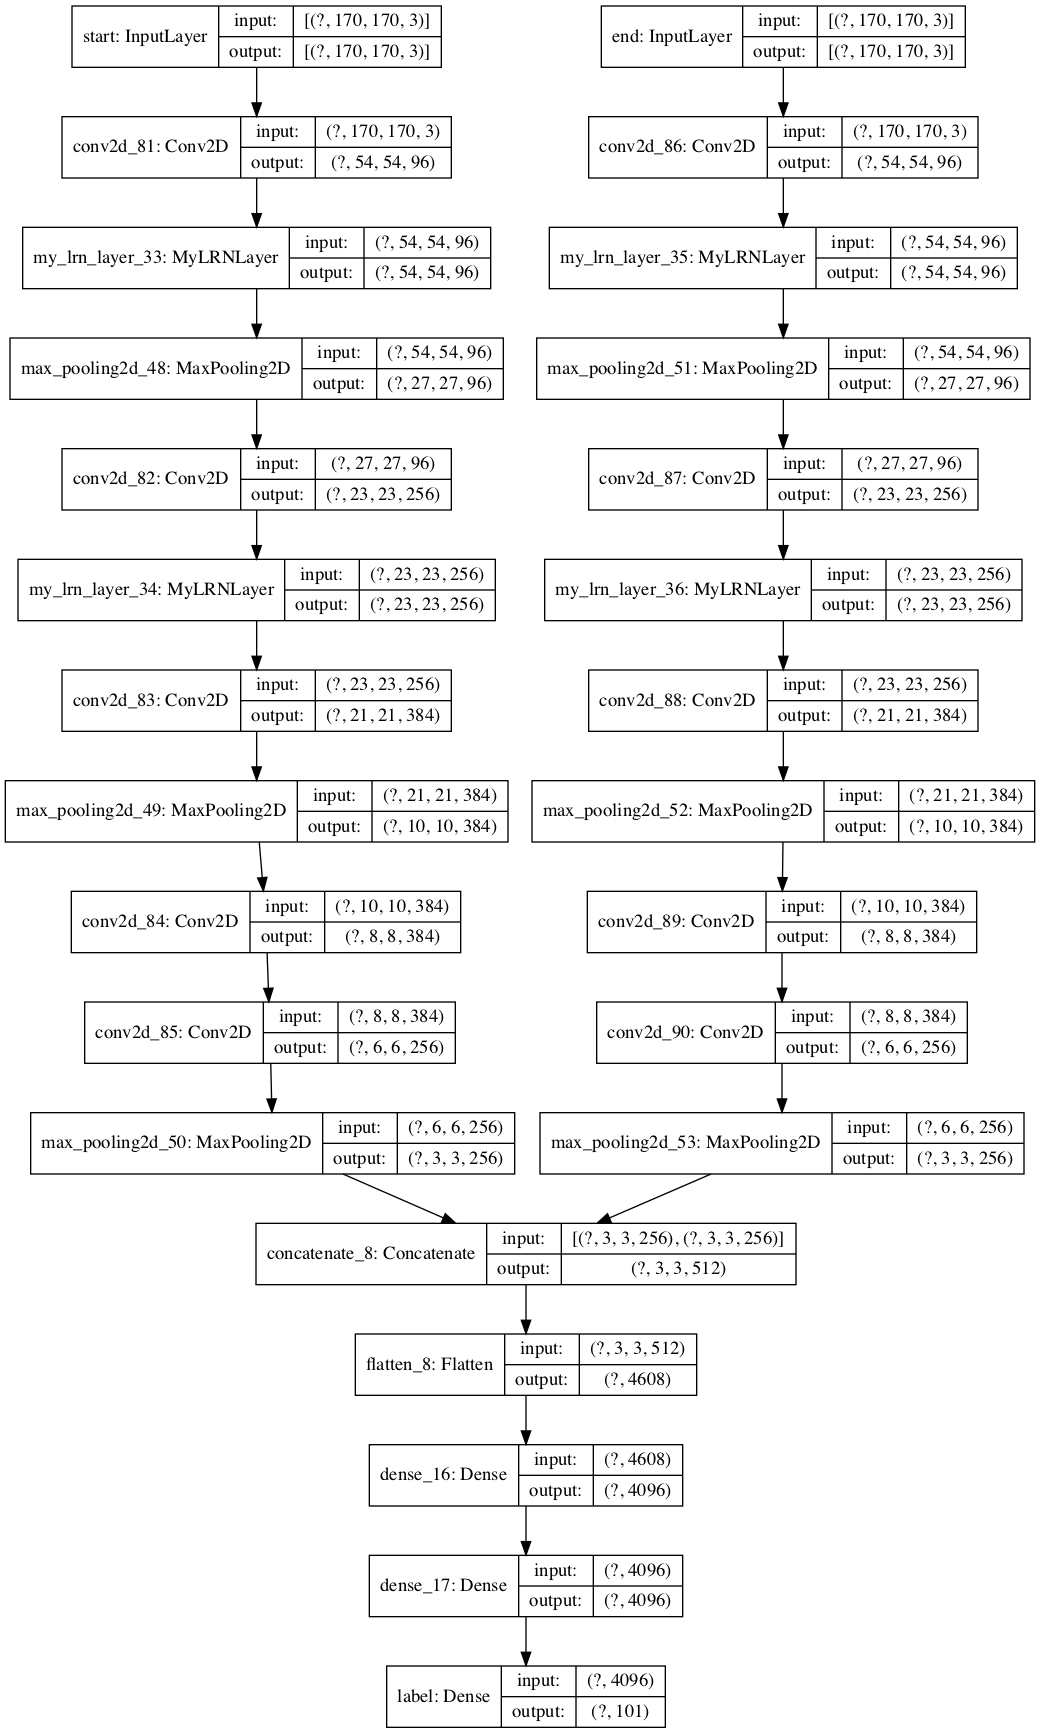

In [69]:
tf.keras.utils.plot_model(late_fusion_model_LRN, 'late_fusion_model_LRN.png', show_shapes=True)

In [48]:
late_fusion_model_LRN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# late_fusion_model_LRN.compile(optimizer='adam',
#               loss=['parse_categorical_crossentropy', 'parse_categorical_crossentropy'])

NameError: name 'late_fusion_model_LRN' is not defined

In [51]:
d = tf.data.Dataset.zip(({'start': train_start, 'end': train_end},train_start_label))
d_batch = d.batch(BATCH_SIZE)

d_test = tf.data.Dataset.zip(({'start': test_start, 'end': test_end},test_start_label))
d_batch_test = d_test.batch(BATCH_SIZE)
# dall = tf.data.Dataset.zip((d, train_start_label))
# dl = tf.data.Dataset.zip({'label': train_start_label})
# dl_batch = d.batch(BATCH_SIZE)

In [100]:
late_fusion_model_LRN.fit(d_batch,
      epochs=1, verbose=1)

299/299 [==============================] - 4397s 15s/step - loss: 0.0155 - acc: 0.9966


## Late Fusion with Batch normalization

Implementing a late fusion modele with batch normilization

In [44]:
train_clip_start = tf.keras.Input(shape=(170, 170, 3), name='start')  # Variable-length sequence of ints
train_clip_end = tf.keras.Input(shape=(170, 170, 3), name='end')  # Variable-length sequence of ints

# Embed each word in the title into a 64-dimensional vector
start_features = tf.keras.layers.Conv2D(96, (11,11), strides=3 , activation='relu', input_shape=(170, 170, 3))(train_clip_start)
start_features = tf.keras.layers.BatchNormalization()(start_features)  
start_features = tf.keras.layers.MaxPooling2D(2, 2)(start_features) 
start_features = tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu')(start_features) 
start_features = tf.keras.layers.BatchNormalization()(start_features) 
start_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(start_features)
start_features = tf.keras.layers.MaxPooling2D(2,2)(start_features)
start_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(start_features)
start_features = tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu')(start_features)
start_features = tf.keras.layers.MaxPooling2D(2,2)(start_features)  


# Embed each word in the title into a 64-dimensional vector
end_features = tf.keras.layers.Conv2D(96, (11,11), strides=3 , activation='relu', input_shape=(170, 170, 3))(train_clip_end)
end_features = tf.keras.layers.BatchNormalization()(end_features)  
end_features = tf.keras.layers.MaxPooling2D(2, 2)(end_features) 
end_features = tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu')(end_features) 
end_features = tf.keras.layers.BatchNormalization()(end_features) 
end_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(end_features)
end_features = tf.keras.layers.MaxPooling2D(2,2)(end_features)
end_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(end_features)
end_features = tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu')(end_features)
end_features = tf.keras.layers.MaxPooling2D(2,2)(end_features)  

# Merge all available features into a single large vector via concatenation
x = tf.keras.layers.concatenate([start_features, end_features])
x =  tf.keras.layers.Flatten()(x)
x =  tf.keras.layers.Dense(4096, activation='relu')(x)
x =  tf.keras.layers.Dense(4096, activation='relu')(x)
label =  tf.keras.layers.Dense(101, activation='softmax')(x)

# Instantiate an end-to-end model predicting both priority and department
late_fusion_model_bn = tf.keras.Model(inputs=[train_clip_start, train_clip_end],
                    outputs=label)

In [45]:
late_fusion_model_bn.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
start (InputLayer)              [(None, 170, 170, 3) 0                                            
__________________________________________________________________________________________________
end (InputLayer)                [(None, 170, 170, 3) 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 54, 54, 96)   34944       start[0][0]                      
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 54, 54, 96)   34944       end[0][0]                        
____________________________________________________________________________________________

In [52]:
late_fusion_model_bn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
late_fusion_model_bn.fit(d_batch,
      epochs=1, verbose=1)

299/299 [==============================] - 4131s 14s/step - loss: 0.0169 - acc: 0.9966


In [54]:
print('\n# Evaluate on test data')
results = late_fusion_model_bn.evaluate(d_batch_test)
print('test loss, test acc:', results)


# Evaluate on test data
    119/Unknown - 1404s 12s/step - loss: 1.0014e-05 - acc: 1.0000test loss, test acc: [1.0013530300057027e-05, 1.0]


# Slow Fusion

For slow fusion we begin by seperating out the data into various into interlocking sets of 4 that span 10 frames

In [35]:
train_multi_frame_1 = ucf101_train.map(format_videos)
train_multi_frame_1 = train_multi_frame_1.map(lambda x: select_frame_from_i_to_T(x,0,4))
train_multi_frame_1 = train_multi_frame_1.map(convert_to_tuple)

train_multi_frame_2 = ucf101_train.map(format_videos)
train_multi_frame_2 = train_multi_frame_2.map(lambda x:select_frame_from_i_to_T(x,2,6))
train_multi_frame_2 = train_multi_frame_2.map(convert_to_tuple)

train_multi_frame_3 = ucf101_train.map(format_videos)
train_multi_frame_3 = train_multi_frame_3.map(lambda x:select_frame_from_i_to_T(x,4,8))
train_multi_frame_3 = train_multi_frame_3.map(convert_to_tuple)

train_multi_frame_4 = ucf101_train.map(format_videos)
train_multi_frame_4 = train_multi_frame_4.map(lambda x:select_frame_from_i_to_T(x,6,10))
train_multi_frame_4 = train_multi_frame_4.map(convert_to_tuple)

# train_multi_frame_T_batches = train_multi_frame_T.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
train_multi_frame_1_batches = train_multi_frame_1.batch(BATCH_SIZE)
train_multi_frame_2_batches = train_multi_frame_2.batch(BATCH_SIZE)
train_multi_frame_3_batches = train_multi_frame_3.batch(BATCH_SIZE)
train_multi_frame_4_batches = train_multi_frame_4.batch(BATCH_SIZE)
# test_multi_frame_1_batches = test_multi_frame_1.batch(BATCH_SIZE)

for image_batch_1, label_batch in train_multi_frame_1_batches.take(1):
    pass
for image_batch_2, label_batch in train_multi_frame_2_batches.take(1):
    pass
for image_batch_3, label_batch in train_multi_frame_3_batches.take(1):
    pass
for image_batch_4, label_batch in train_multi_frame_4_batches.take(1):
    pass

print('1', image_batch_1.shape)
print('2', image_batch_2.shape)
print('3', image_batch_3.shape)
print('4', image_batch_4.shape)

1 (32, 4, 170, 170, 3)
2 (32, 4, 170, 170, 3)
3 (32, 4, 170, 170, 3)
4 (32, 4, 170, 170, 3)


In [ ]:
# inputs_1 = tf.keras.Input(shape=(32,))  # Returns a placeholder tensor
# inputs_T = tf.keras.Input(shape=(32,))  # Returns a placeholder tensor

# # A layer instance is callable on a tensor, and returns a tensor.
# x = layers.Dense(64, activation='relu')(inputs)
# x = layers.Dense(64, activation='relu')(x)
# predictions = layers.Dense(10, activation='softmax')(x)

# model = tf.keras.Model(inputs=inputs, outputs=predictions)

# # The compile step specifies the training configuration.
# model.compile(optimizer=tf.train.RMSPropOptimizer(0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Trains for 5 epochs
# model.fit(data, labels, batch_size=32, epochs=5)

In [36]:
train_clip_1 = tf.keras.Input(shape=(4,170, 170, 3), name='clip_1')  # Variable-length sequence of ints
train_clip_2 = tf.keras.Input(shape=(4,170, 170, 3), name='clip_2')  # Variable-length sequence of ints
train_clip_3 = tf.keras.Input(shape=(4,170, 170, 3), name='clip_3')  # Variable-length sequence of ints
train_clip_4 = tf.keras.Input(shape=(4,170, 170, 3), name='clip_4')  # Variable-length sequence of ints
 
    
train_clip_1_features = tf.keras.layers.Conv3D(96, (4,11,11), strides=2 , activation='relu', input_shape=(4,170, 170, 3))(train_clip_1)
train_clip_1_features = tf.keras.layers.Reshape((54, 54,96))(train_clip_1_features)  
train_clip_1_features = tf.keras.layers.BatchNormalization()(train_clip_1_features) 
train_clip_1_features = tf.keras.layers.MaxPooling2D(2, 2)(train_clip_1_features) 

train_clip_2_features = tf.keras.layers.Conv3D(96, (4,11,11), strides=2 , activation='relu', input_shape=(4,170, 170, 3))(train_clip_2)
train_clip_2_features = tf.keras.layers.Reshape((54, 54,96))(train_clip_2_features)  
train_clip_2_features = tf.keras.layers.BatchNormalization()(train_clip_2_features) 
train_clip_2_features = tf.keras.layers.MaxPooling2D(2, 2)(train_clip_2_features)

train_clip_3_features = tf.keras.layers.Conv3D(96, (4,11,11), strides=2 , activation='relu', input_shape=(4,170, 170, 3))(train_clip_3)
train_clip_3_features = tf.keras.layers.Reshape((54, 54,96))(train_clip_3_features)  
train_clip_3_features = tf.keras.layers.BatchNormalization()(train_clip_3_features) 
train_clip_3_features = tf.keras.layers.MaxPooling2D(2, 2)(train_clip_3_features)

train_clip_4_features = tf.keras.layers.Conv3D(96, (4,11,11), strides=2 , activation='relu', input_shape=(4,170, 170, 3))(train_clip_4)
train_clip_4_features = tf.keras.layers.Reshape((54, 54,96))(train_clip_4_features)  
train_clip_4_features = tf.keras.layers.BatchNormalization()(train_clip_4_features) 
train_clip_3_features = tf.keras.layers.MaxPooling2D(2, 2)(train_clip_4_features)

# train_clip_1_features = tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu')

first_half = tf.keras.layers.concatenate([train_clip_1_features, train_clip_2_features])
second_half = tf.keras.layers.concatenate([train_clip_3_features, train_clip_3_features])


first_half = tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu')(first_half) 
first_half = tf.keras.layers.BatchNormalization()(first_half)  
first_half = tf.keras.layers.MaxPooling2D(2, 2)(first_half)

second_half = tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu')(second_half) 
second_half = tf.keras.layers.BatchNormalization()(second_half)  
second_half = tf.keras.layers.MaxPooling2D(2, 2)(second_half) 

combined =  tf.keras.layers.concatenate([first_half, second_half])

combined = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(combined) 
combined = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(combined) 
combined = tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu')(combined) 
combined = tf.keras.layers.MaxPooling2D(2,2)(combined)   
combined = tf.keras.layers.Flatten()(combined) 
combined = tf.keras.layers.Dense(4096, activation='relu')(combined) 
combined =  tf.keras.layers.Dense(4096, activation='relu')(combined) 
label =  tf.keras.layers.Dense(101, activation='softmax')(combined)

In [37]:
slow_fusion_model_bn = tf.keras.Model(inputs=[train_clip_1,train_clip_2,train_clip_3, train_clip_4],
                    outputs=label)

TypeError: 'MapDataset' object is not subscriptable

In [73]:
ucf101_train.map?

In [102]:
tf.keras.layers.Conv3D?

In [109]:
tfds.as_numpy?

In [104]:
# tx = tf.zeros([1,2, 2, 3])
# print(tx)
# txr = tf.reshape(tx, [2, 2, 3])
# print(txr)